In [220]:
import torch
import torch.nn as nn
import numpy as np

#import dataloader and dataset from pyTorch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import os
import csv
import torch
from PIL import Image
import math
import copy
import matplotlib.pyplot as plt
from datetime import datetime

Let's make a pyTorch dataset class that will utilize the digits first

In [221]:
class ImageDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir

        self.image_files = [f"{i}.png" for i in range(1, len(os.listdir(data_dir)))]  # Assuming there's 1 labels.csv file
        self.labels = []

        with open(os.path.join(data_dir, "labels.csv"), "r") as csvfile:
            csv_reader = csv.reader(csvfile)
            for row in csv_reader:
                self.labels.append(int(row[0]))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")
        image = torch.from_numpy(np.array(image))
        label = self.labels[idx]

        return image.to(torch.float32), label

In [222]:
train_data_digit = ImageDataset("digitdata/processed/training")
test_data_digit = ImageDataset("digitdata/processed/test")
validation_data_digit = ImageDataset("digitdata/processed/validation")

train_data_face = ImageDataset("facedata/processed/facedatatest")
test_data_face = ImageDataset("facedata/processed/facedatatrain")
validation_data_face = ImageDataset("facedata/processed/facedatavalidation")

In [223]:
#Obtains the data loader for train, test, and validation based on how much of the data you want to utilize
#partition is a decimal between 0 and 1 representing the percentage of training data you want to use

def get_data_loader(train_data, test_data, validation_data, batch_size, partition):
    if partition > 1:
        print("Partition must be a decimal between 0 and 1")
        return
    if partition == 1:
        return DataLoader(train_data, batch_size=batch_size, shuffle=True), DataLoader(test_data, batch_size=batch_size, shuffle=False), DataLoader(validation_data, batch_size=batch_size, shuffle=False)
    if partition < 1:
        train_data_partitioned, _ = torch.utils.data.random_split(train_data, [int((len(train_data)*partition)), len(train_data) - int((len(train_data)*partition))])
        return DataLoader(train_data_partitioned, batch_size=batch_size, shuffle=True), DataLoader(test_data, batch_size=batch_size, shuffle=False), DataLoader(validation_data, batch_size=batch_size, shuffle=False)

In [224]:
# Define the model which classifies digit images into 10 classes

class ConvolutionalClassifierDigit(nn.Module):
    def __init__(self):
        super(ConvolutionalClassifierDigit, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.log_softmax(x, dim=1)
        return output
    
# Define the model which classifies face images into 2 classes

class ConvolutionalClassifierFace(nn.Module):
    def __init__(self):
        super(ConvolutionalClassifierFace, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 15 * 17, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 15 * 17)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

In [225]:
#HYPERPARAMETERS

device = 'cuda:0'
num_epochs = 200
batch_size = 32
learning_rate = 0.001

criterion_digits = nn.CrossEntropyLoss()
criterion_face = nn.BCELoss()

In [239]:
def get_acc(model, loader, isFace=False):
    #gets the accuracy of the model on the validation data
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            images = images.unsqueeze(1)
            outputs = model(images)
            total += labels.size(0)

            if isFace:
                correct += torch.sum((outputs.squeeze() > 0.5).int() == labels.bool().int())
            else:
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
    return 100 * correct / total

#gets the standard deviation of the model relative to accuracy per batch
def get_std(model, loader, isFace=False):
    model.eval()
    correct = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            images = images.unsqueeze(1)
            outputs = model(images).cpu()

            if isFace:
                correct.append(100 * torch.sum((outputs.squeeze() > 0.5).int() == labels.cpu().bool().int()) / labels.cpu().size(0))
            else:
                _, predicted = torch.max(outputs.data, 1)
                correct.append(100 * (predicted == labels).sum().item() / labels.size(0)) 
    return np.std(correct)

In [227]:
def train(model, train_loader, val_loader, optimizer, num_epochs=10, verbose=True, device='cuda:0', select_model=False, isFace=False):
  model = model.to(device)  # Move the model to device.  
    
  acc_train = 0.
  best_acc_val = 0.
  start_time = datetime.now()  # Keep track of training time. 
  best_state_dict = None
  num_continuous_fails = 0
  tolerance = 50

  for epoch in range(num_epochs):
    correct = 0
    totals = 0
    model.train()  # This turns on the training mode (e.g., enable dropout).
    loss_total = 0.

    for i, (inputs, labels) in enumerate(train_loader, 0):
      inputs, labels = inputs.to(device), labels.to(device)
      inputs = inputs.unsqueeze(1)
      optimizer.zero_grad()
      outputs = model(inputs)
      totals += labels.size(0)
        
      if isFace:
        correct += torch.sum((outputs.squeeze() > 0.5).int() == labels.bool().int())
        loss = criterion_face(outputs.squeeze(), labels.float())
      else:
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        loss = criterion_digits(outputs, labels)

      loss.backward()
      optimizer.step()          

      loss_total += loss.item()

      if math.isnan(loss_total):
        print('Stopping training because loss is NaN')
        break

    # Check validation and training performance at the end of every epoch.

    acc_train = 100 * correct / totals
    
    acc_val = get_acc(model, val_loader, isFace=isFace)
    loss_avg = loss_total / len(train_loader.dataset)

    if verbose and (epoch+1) % 5 == 0:
      print('Epoch {:3d} | avg loss {:8.4f} | train acc {:2.2f} | val acc {:2.2f}'.format(epoch + 1, loss_avg, acc_train, acc_val))

    if acc_val > best_acc_val: 
      num_continuous_fails = 0
      best_acc_val = acc_val
      if select_model:
        best_state_dict = copy.deepcopy(model.state_dict())
    else:
      num_continuous_fails += 1
      if num_continuous_fails > tolerance:
        print('Early stopping')
        break         
  
  train_time = datetime.now() - start_time
  if verbose: 
    print('Final loss {:8.4f} | final train acc {:2.2f} | best val acc {:2.2f} | train time {:d} secs'.format(loss_total, acc_train, best_acc_val, train_time.seconds))

  if select_model and best_state_dict is not None:
    model.load_state_dict(best_state_dict)
  model.eval()
  return loss_total, acc_train, best_acc_val, train_time

Let's Evaluate the Digit Model First

In [228]:
partitions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_digit = {}

#train anew model on the digit dataset for different training set sizes
for partition in partitions:
    model_digit = ConvolutionalClassifierDigit()
    optimizer_digit = torch.optim.Adam(model_digit.parameters(), lr=learning_rate)

    print("Training on partition size: ", partition)
    train_digit, test_digit, val_digit = get_data_loader(train_data_digit, test_data_digit, validation_data_digit, 32, partition)
    running_loss, acc_train, best_acc_val, train_time = train(model_digit, train_digit, val_digit, optimizer_digit, 
                                                        num_epochs=num_epochs, verbose=True, device=device, select_model=True)
    
    acc_test = get_acc(model_digit, test_digit, isFace=False)
    std_test = get_std(model_digit, test_digit, isFace=False)
    print('Final Test Accuracy: {0}'.format(acc_test))
    print('Final Test Standard Deviation: {0}'.format(std_test))
    #store the results but move it to cpu and convert to numpy
    results_digit[partition] = [train_time, running_loss, acc_train, best_acc_val, acc_test, std_test]

Training on partition size:  0.1
Epoch   5 | avg loss   0.0182 | train acc 81.40 | val acc 85.10
Epoch  10 | avg loss   0.0060 | train acc 93.80 | val acc 86.50
Epoch  15 | avg loss   0.0054 | train acc 94.40 | val acc 88.70
Epoch  20 | avg loss   0.0026 | train acc 97.40 | val acc 87.60
Epoch  25 | avg loss   0.0021 | train acc 97.80 | val acc 85.60
Epoch  30 | avg loss   0.0013 | train acc 99.00 | val acc 87.60
Epoch  35 | avg loss   0.0045 | train acc 96.00 | val acc 87.80
Epoch  40 | avg loss   0.0026 | train acc 97.80 | val acc 87.80
Epoch  45 | avg loss   0.0022 | train acc 97.20 | val acc 87.00
Epoch  50 | avg loss   0.0015 | train acc 97.60 | val acc 86.80
Epoch  55 | avg loss   0.0040 | train acc 96.40 | val acc 89.20
Epoch  60 | avg loss   0.0033 | train acc 97.00 | val acc 87.10
Epoch  65 | avg loss   0.0015 | train acc 98.40 | val acc 86.20
Epoch  70 | avg loss   0.0014 | train acc 98.80 | val acc 88.10
Epoch  75 | avg loss   0.0027 | train acc 97.80 | val acc 87.60
Epoch  

Now, let's see how the model does on the face dataset

In [240]:
partitions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_face = {}
num_epochs = 200
learning_rate = 0.0001

#train anew model on the digit dataset for different training set sizes
for partition in partitions:
    model_face = ConvolutionalClassifierFace()
    optimizer_face = torch.optim.Adam(model_face.parameters(), lr=learning_rate)

    print("Training on partition size: ", partition)
    train_face, test_face, val_face = get_data_loader(train_data_face, test_data_face, validation_data_face, 32, partition)
    running_loss, acc_train, best_acc_val, train_time = train(model_face, train_face, val_face, optimizer_face, 
                                                        num_epochs=num_epochs, verbose=True, device=device, select_model=True, isFace=True)
    
    acc_test = get_acc(model_face, test_face, isFace=True)
    std_test = get_std(model_face, test_face, isFace=True)
    print('Final Test Accuracy: {0}'.format(acc_test))
    print('Final Test Standard Deviation: {0}'.format(std_test))
    
    results_face[partition] = [train_time, running_loss, acc_train, best_acc_val, acc_test, std_test]

Training on partition size:  0.1
Epoch   5 | avg loss   0.2302 | train acc 33.33 | val acc 48.17
Epoch  10 | avg loss   0.1035 | train acc 66.67 | val acc 51.50
Epoch  15 | avg loss   0.0649 | train acc 66.67 | val acc 52.16
Epoch  20 | avg loss   0.0804 | train acc 60.00 | val acc 75.08
Epoch  25 | avg loss   0.0989 | train acc 46.67 | val acc 49.17
Epoch  30 | avg loss   0.0553 | train acc 60.00 | val acc 60.47
Epoch  35 | avg loss   0.0212 | train acc 86.67 | val acc 53.16
Epoch  40 | avg loss   0.0094 | train acc 86.67 | val acc 83.39
Epoch  45 | avg loss   0.0133 | train acc 93.33 | val acc 81.40
Epoch  50 | avg loss   0.0064 | train acc 93.33 | val acc 72.76
Epoch  55 | avg loss   0.0013 | train acc 100.00 | val acc 78.41
Epoch  60 | avg loss   0.0032 | train acc 100.00 | val acc 77.08
Epoch  65 | avg loss   0.0063 | train acc 93.33 | val acc 77.74
Epoch  70 | avg loss   0.0019 | train acc 100.00 | val acc 84.05
Epoch  75 | avg loss   0.0101 | train acc 86.67 | val acc 84.72
Epoc

In [241]:
#convert the results within the dictionaries to numpy and take them off the gpu

def convert_dictionary(dict):
    for key in dict.keys():
        try:
            dict[key] = [value.cpu().numpy() if type(value) == torch.Tensor else value for value in dict[key]]
        except:
            continue
    return dict

results_digit = convert_dictionary(results_digit)
results_face = convert_dictionary(results_face)

In [248]:
print(results_digit[0.8][-2])

94.6


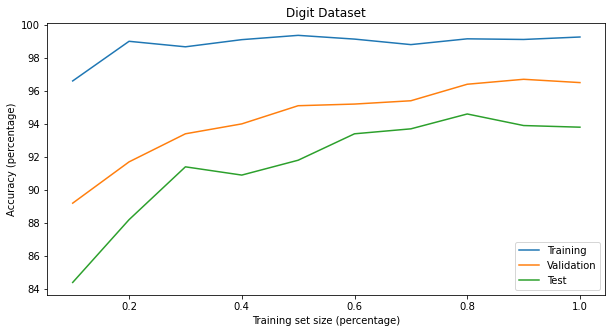

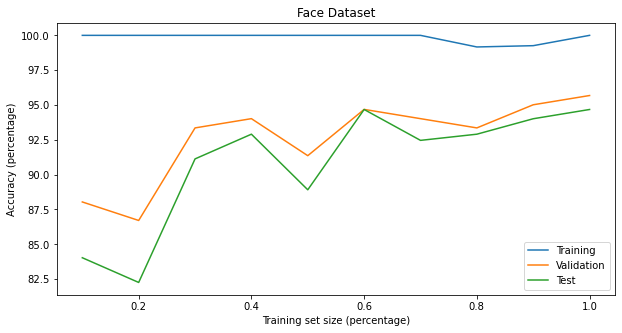

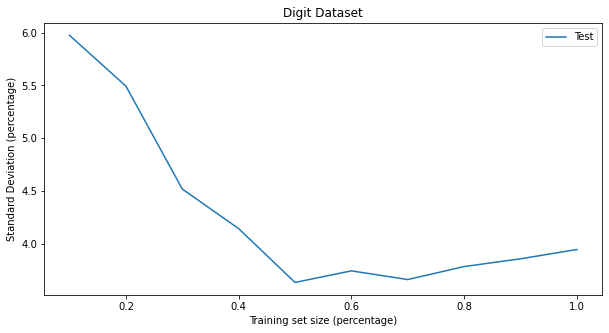

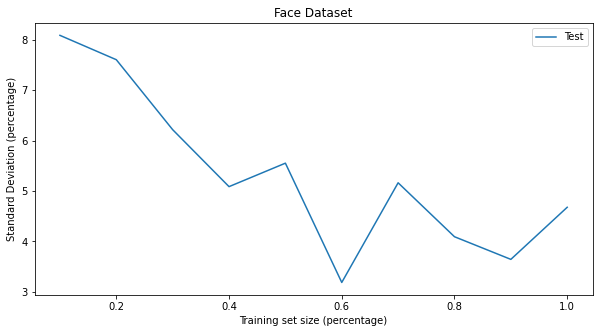

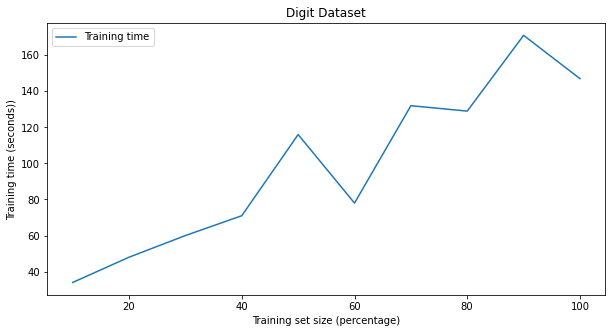

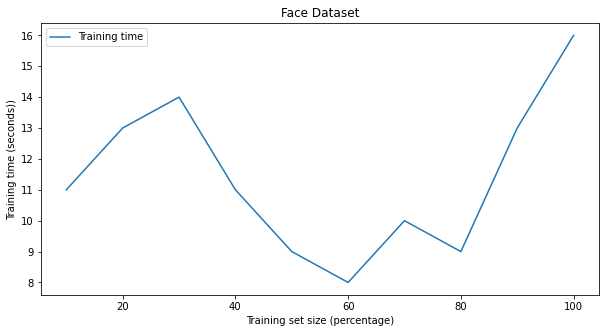

In [243]:
from matplotlib import pyplot as plt

#plot the accuracy versus the training size

def plot_results(results, title):
    #plots the results of the training
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel('Training set size (percentage)')
    plt.ylabel('Accuracy (percentage)')
    plt.plot(list(results.keys()), [results[key][2] for key in results.keys()], label='Training')
    plt.plot(list(results.keys()), [results[key][3] for key in results.keys()], label='Validation')
    plt.plot(list(results.keys()), [results[key][4] for key in results.keys()], label='Test')
    plt.legend()
    plt.show()

plot_results(results_digit, 'Digit Dataset')
plot_results(results_face, 'Face Dataset')

#plot the standard devition of the accuracy per batch
def plot_std(results, title):
    #plots the results of the training
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel('Training set size (percentage)')
    plt.ylabel('Standard Deviation (percentage)')
    plt.plot(list(results.keys()), [results[key][5] for key in results.keys()], label='Test')
    plt.legend()
    plt.show()

plot_std(results_digit, 'Digit Dataset')
plot_std(results_face, 'Face Dataset')

#plot the training time versus the training size

def plot_time(results, title):
    #plots the results of the training
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel('Training set size (percentage)')
    plt.ylabel('Training time (seconds))')
    plt.plot(np.array(list(results.keys()))*100, [results[key][0].seconds for key in results.keys()], label='Training time')
    plt.legend()
    plt.show()

plot_time(results_digit, 'Digit Dataset')
plot_time(results_face, 'Face Dataset')

Predicted:  5


c:\Users\Aaron\Anaconda3\envs\deepLearningCuda11\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


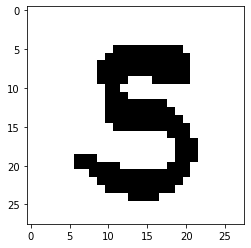

Predicted:  6


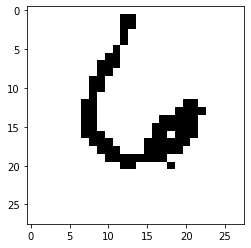

Predicted:  3


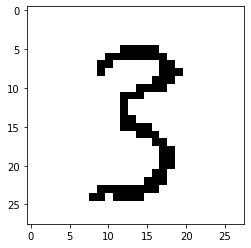

Predicted:  6


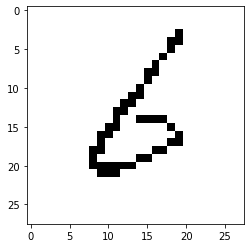

Predicted:  5


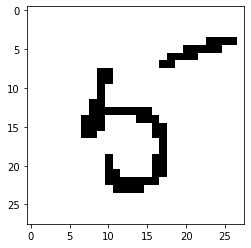

Predicted:  4


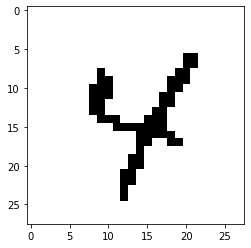

Predicted:  Not Face


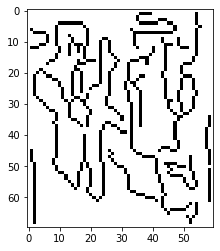

Predicted:  Not Face


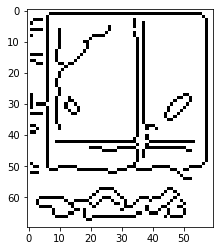

Predicted:  Not Face


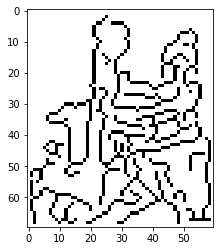

Predicted:  Face


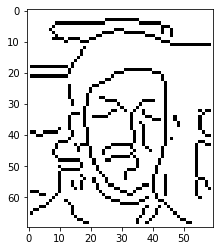

Predicted:  Face


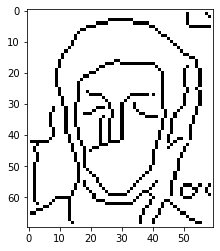

Predicted:  Not Face


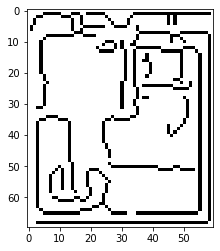

In [244]:
#Let's visualize our best model's performance on the test set on a couple of images and show the results

def visualize_model(model, test_loader, isFace=False):
    #visualizes the model's performance on the test set
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.unsqueeze(1))
            
            if isFace:
                predicted = (outputs.squeeze() > 0.5).cpu().numpy().astype(int)
                print('Predicted: ', 'Face' if predicted[3] == 1 else 'Not Face')
            else:
                _, predicted = torch.max(outputs.data, 1)
                print('Predicted: ', predicted[3].item())
            plt.imshow(images[3, :, :].cpu().numpy(), cmap='gray')
            plt.show()
            
            if i == 5:
                break

visualize_model(model_digit, test_digit)
visualize_model(model_face, test_face, isFace=True)